In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from utils import *

# Process results

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_11/')

In [24]:
errors = compute_errors(data_path, sample=50, force_sample=True)

  0%|          | 0/10 [00:00<?, ?it/s]

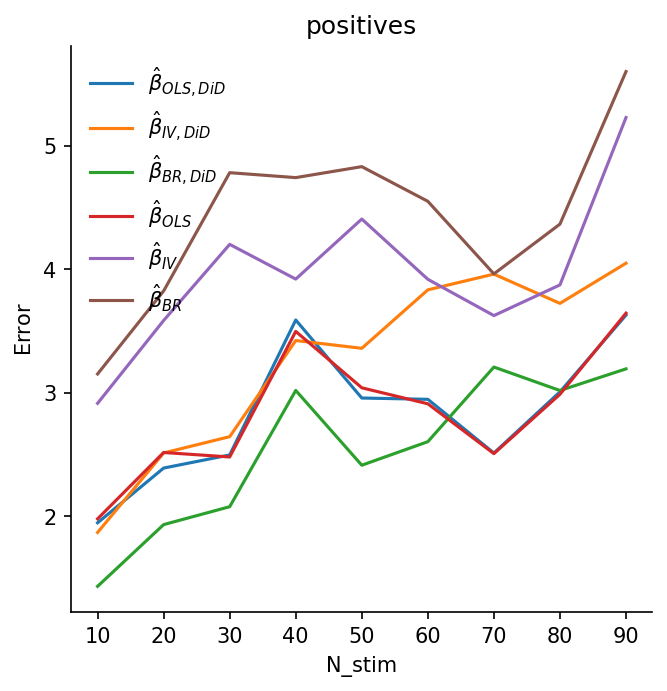

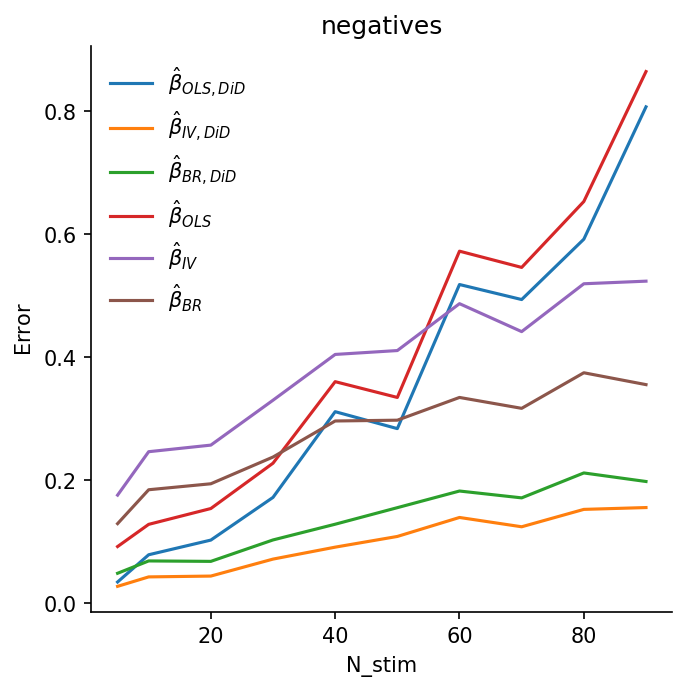

In [25]:
plot_errors(errors, 'n_stim')

In [4]:
error_trials = compute_error_trials(data_path)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [6]:
errors = compute_error_confidence(errors, error_trials)

In [8]:
errors['positives'][['n_stim', 'error_ols_iv_did_pval', 'error_ols_iv_did_statistic']]

,n_stim,error_ols_iv_did_pval,error_ols_iv_did_statistic
0,80.0,3.896560e-18,0.0
1,60.0,3.896560e-18,0.0
2,20.0,3.896560e-18,0.0
3,5.0,3.896560e-18,0.0
4,50.0,3.896560e-18,0.0
5,40.0,3.896560e-18,0.0
6,30.0,3.896560e-18,0.0
7,10.0,3.896560e-18,0.0
8,70.0,3.896560e-18,0.0
9,90.0,3.896560e-18,0.0


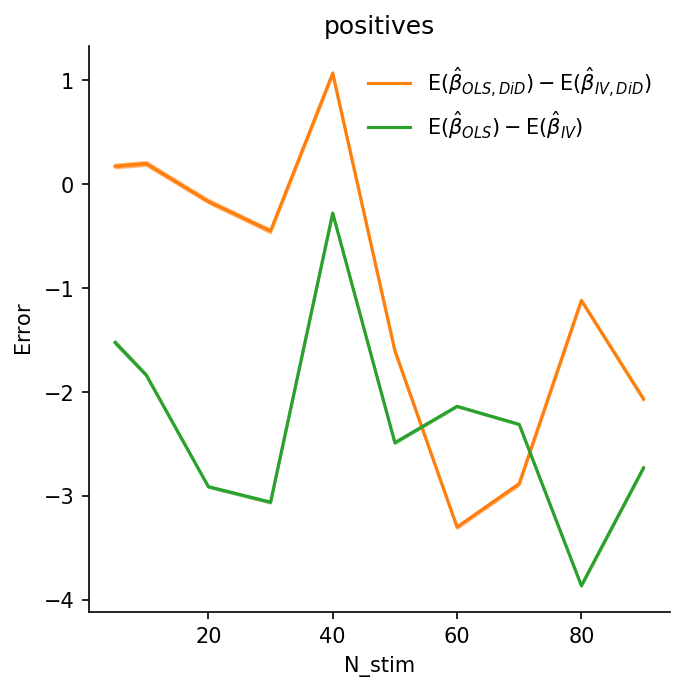

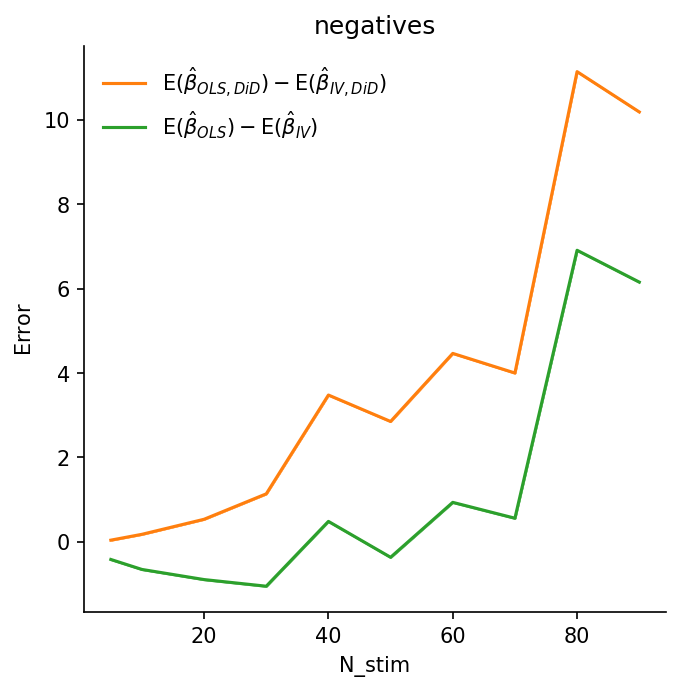

In [9]:
plot_error_difference(errors, 'n_stim')

# Convergence

In [10]:
error_convergence = compute_error_convergence(data_path)

  0%|          | 0/1600 [00:00<?, ?it/s]

In [11]:
error_convergence_trials = compute_error_convergence_trials(data_path)

  0%|          | 0/15000 [00:00<?, ?it/s]

In [12]:
samples = compute_all_samples(data_path)

  0%|          | 0/10 [00:00<?, ?it/s]

In [13]:
index = int(errors['positives'].query('n_stim==90').index.values)
index

9

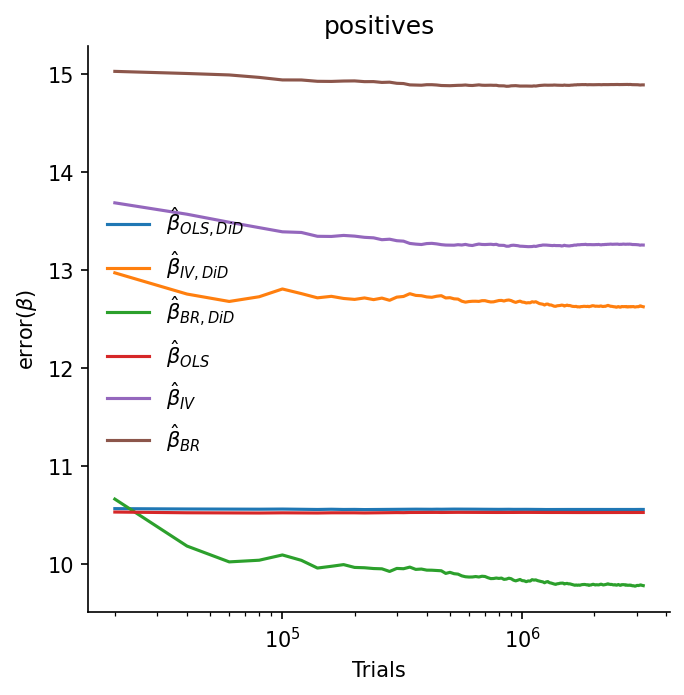

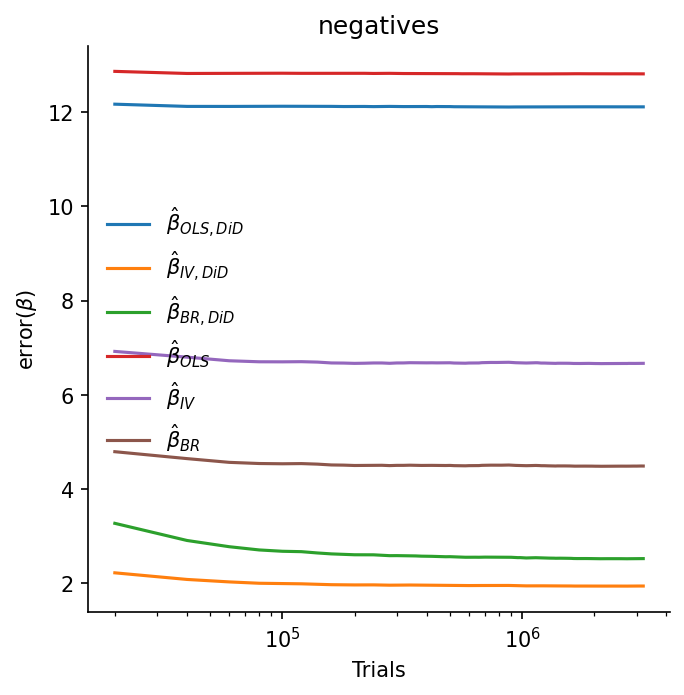

In [14]:
plot_error_convergence(error_convergence, index)

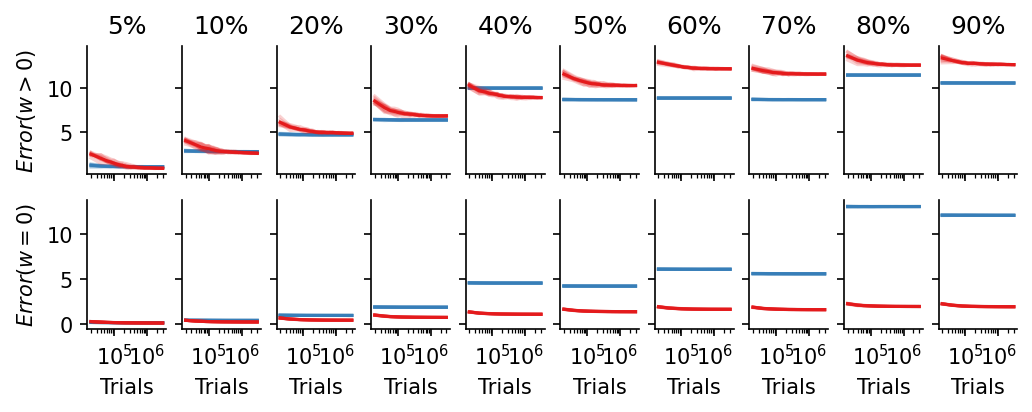

In [18]:
fig, axs = plt.subplots(2, 10, sharex=True, sharey='row', figsize=(8,2.5), dpi=150)
for i, (n_stim, df) in enumerate(errors['positives'].groupby('n_stim')):
    index = int(df.index.values)
    plot_error_convergence_trials( 
        error_convergence_trials, 
        index, 
        keys=['error_beta_ols_did','error_beta_iv_did'], 
        axs=axs.T[i], 
#         legend=i==4, 
        legend=False,
        xlabels=(False,True), ylabels=[i==0]*2)
    axs[0,i].set_title(f'{n_stim:.0f}%')
savefig('stim_percentage_convergence')

# Regression

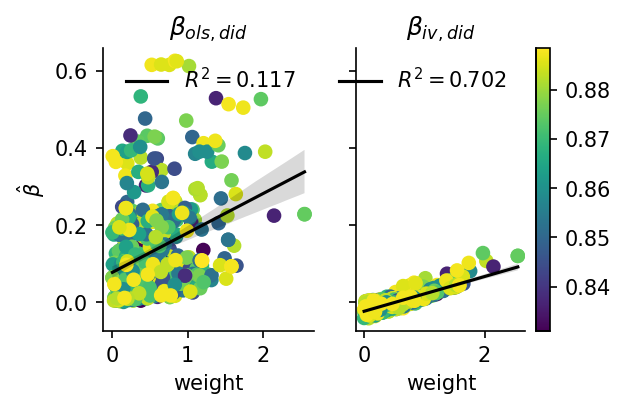

In [16]:
plot_regression(samples, index, ['beta_ols_did','beta_iv_did'])

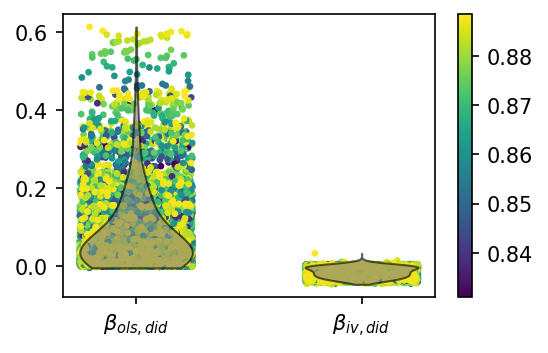

In [17]:
plot_false_positives(samples, index, ['beta_ols_did', 'beta_iv_did'])